In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
import os
import numpy as np 
import cv2
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import tensorflow as tf

In [3]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2


In [4]:
    X = np.load('data_train.npy').T
    t = np.load('t_train_corrected.npy')

In [5]:
X = np.array([ cv2.resize(x.reshape(300,300),(300,100)).reshape(300*100) for x in X ])

In [6]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.33)
t_test_de=t_test

In [7]:
class_names= ['x','square root','plus sign','negative sign',
                'equal','percent','partial','product','pi','summation']

t_train= np_utils.to_categorical(t_train)
t_test= np_utils.to_categorical(t_test)
num_classes=t_train.shape[1]

In [8]:
X_train_re = X_train.reshape(6051, 300, 100)
t_train_re = t_train
X_test_re = X_test.reshape(2981, 300, 100)
t_test_re = t_test

In [9]:
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = X_train_re.shape
IMAGE_CHANNELS = 3

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS)

IMAGE_WIDTH: 300
IMAGE_HEIGHT: 100
IMAGE_CHANNELS: 3


In [11]:
X_train_with_chanels = X_train_re.reshape(
    X_train_re.shape[0],
    100,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

X_test_with_chanels = X_test_re.reshape(
    X_test_re.shape[0],
    100,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

# Normalizing Data

In [12]:
X_train_normalized = X_train_with_chanels / 255
X_test_normalized = X_test_with_chanels / 255

In [13]:
print(X_train_normalized.shape, t_train.shape, X_test_normalized.shape, t_test.shape)

(6051, 100, 100, 3) (6051, 10) (2981, 100, 100, 3) (2981, 10)


In [14]:
from tensorflow import keras
from tensorflow.keras import layers

# Transfer Learning

In [15]:
def inceptV3_model(D,num_classes):
    base_model = tf.keras.applications.inception_v3.InceptionV3(
        weights="imagenet",
        input_shape=(D, D, 3),
        include_top=False,
    )
    # Freeze the base_model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(D, D, 3))
    data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)
    x = data_augmentation(inputs)

    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    
    #here we can add our additional layers for training this model on our own dataset
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(num_classes)(x)

    model = tf.keras.Model(inputs, outputs)
    base_model.trainable=True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy()],
    )
    
    return model

In [16]:
D=100

# Fitting Model

In [17]:
inceptv3 = inceptV3_model(D,num_classes)
training = inceptv3.fit(X_train_normalized, t_train, validation_data=(X_test_normalized,t_test),epochs=20, batch_size=64, verbose=2)
score= inceptv3.evaluate(X_test_normalized, t_test, verbose=0)
print('The error is: %.2f%%'%(100-score[1]*100))

Epoch 1/20
95/95 - 216s - loss: 0.2872 - binary_accuracy: 0.9046 - val_loss: 0.1908 - val_binary_accuracy: 0.9212 - 216s/epoch - 2s/step
Epoch 2/20
95/95 - 209s - loss: 0.1595 - binary_accuracy: 0.9422 - val_loss: 0.1648 - val_binary_accuracy: 0.9427 - 209s/epoch - 2s/step
Epoch 3/20
95/95 - 245s - loss: 0.1235 - binary_accuracy: 0.9571 - val_loss: 0.1041 - val_binary_accuracy: 0.9644 - 245s/epoch - 3s/step
Epoch 4/20
95/95 - 266s - loss: 0.1045 - binary_accuracy: 0.9642 - val_loss: 0.0964 - val_binary_accuracy: 0.9663 - 266s/epoch - 3s/step
Epoch 5/20
95/95 - 246s - loss: 0.0953 - binary_accuracy: 0.9683 - val_loss: 0.0940 - val_binary_accuracy: 0.9685 - 246s/epoch - 3s/step
Epoch 6/20
95/95 - 256s - loss: 0.0882 - binary_accuracy: 0.9700 - val_loss: 0.0881 - val_binary_accuracy: 0.9705 - 256s/epoch - 3s/step
Epoch 7/20
95/95 - 246s - loss: 0.0787 - binary_accuracy: 0.9730 - val_loss: 0.0789 - val_binary_accuracy: 0.9730 - 246s/epoch - 3s/step
Epoch 8/20
95/95 - 244s - loss: 0.0747 - 

# Running Test set

In [18]:
validation_loss, validation_accuracy = inceptv3.evaluate(X_test_normalized, t_test)

94/94 [==============================] - 14s 151ms/step - loss: 0.0757 - binary_accuracy: 0.9782


# PLOTTING LOSS AND ACCURACY 

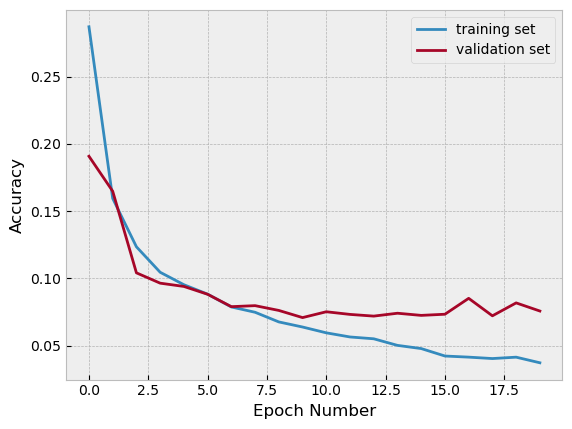

In [20]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training.history['loss'], label='training set')
plt.plot(training.history['val_loss'], label='validation set')
plt.legend()

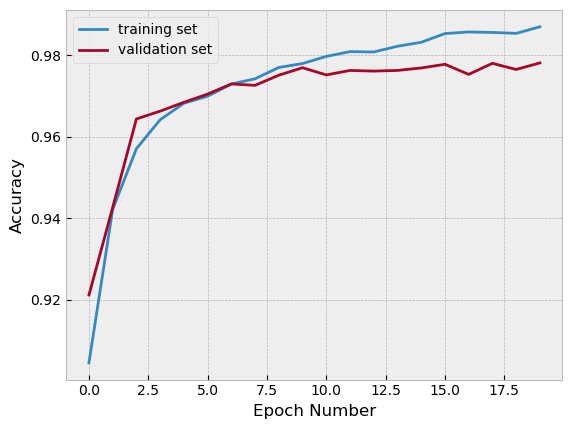

In [22]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training.history['binary_accuracy'], label='training set')
plt.plot(training.history['val_binary_accuracy'], label='validation set')
plt.legend()

# MODEL

In [25]:
inceptv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                             

In [26]:
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

Validation loss:  0.0756683349609375
Validation accuracy:  0.9781616926193237


# SAVING MODEL

In [27]:
model_name = 'handwritten_math_recognition_cnn.h5'
inceptv3.save(model_name, save_format='h5')

In [28]:
loaded_model = tf.keras.models.load_model(model_name)

In [29]:
predictions_one_hot = loaded_model.predict([X_test_normalized])

94/94 [==============================] - 15s 133ms/step


In [30]:
print('predictions_one_hot:', predictions_one_hot.shape)

predictions_one_hot: (2981, 10)


In [31]:
import pandas as pd

In [32]:
predictions = np.argmax(predictions_one_hot, axis=1)
pd.DataFrame(predictions)

,0
0,7
1,2
2,3
3,8
4,0
...,...
2976,8
2977,4
2978,9
2979,9


In [33]:
tf.math.confusion_matrix(
    t_test_de,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[296,   2,   1,   1,   1,   5,   2,   0,   6,   2],
       [  7, 277,   3,   6,   1,   1,   1,   0,   8,   0],
       [ 14,   0, 249,   4,   1,   1,   0,   1,   0,   0],
       [  5,   0,   2, 270,  14,   1,   0,   0,   1,   2],
       [ 14,   0,   2,   7, 273,   4,   2,   2,   2,   5],
       [  8,   0,   4,   4,   3, 269,   0,   0,   0,   0],
       [ 15,   1,   1,   1,   3,   1, 275,   1,   3,   3],
       [  9,   3,   0,   0,   3,   4,   0, 233,  53,   1],
       [ 36,   0,   2,   0,   1,   4,   1,  29, 213,   3],
       [ 11,   0,   0,   0,   3,   5,   1,   0,   1, 277]])>

# Plotting Confusion Matrix

In [34]:
import seaborn as sn

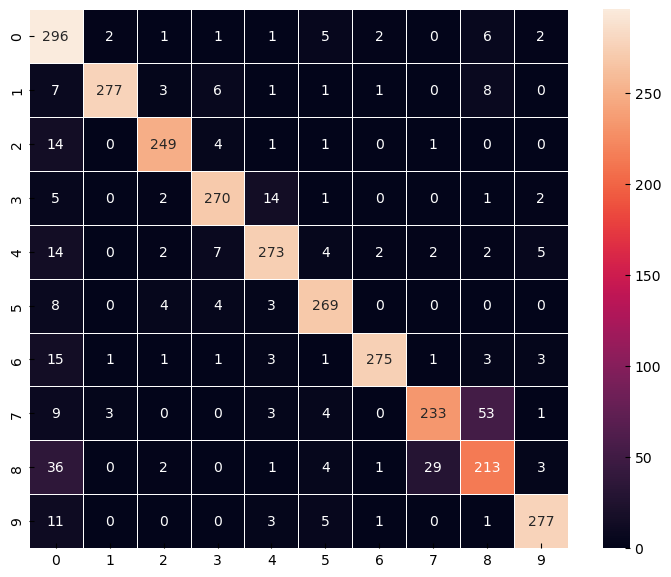

In [35]:
confusion_matrix = tf.math.confusion_matrix(t_test_de, predictions)
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()